In [341]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
import random
import operator

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn import datasets, linear_model, cross_validation, grid_search, svm, ensemble, kernel_ridge

In [342]:
np.random.seed(10)
random.seed(10)

In [343]:
def rmspe(y, yhat):
    y = y.astype('float')
    yhat = yhat.astype('float')
    inner = ((y-yhat)/y)**2
    return (np.mean(inner))**0.5

In [344]:
# get rossmann, store, & test csv files as a DataFrame
train_df  = pd.read_csv("../input/train.csv")
store_df     = pd.read_csv("../input/store.csv")
test_df      = pd.read_csv("../input/test.csv")

### Data Preprocessing ###

In [345]:
# Got a warning about column 7 during import.
# Fix it by change all 0 to '0'
train_df.loc[train_df['StateHoliday'] == 0, 'StateHoliday'] = '0'

# Convert the date column in train and test data
train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y-%m-%d")
test_df['Date'] = pd.to_datetime(test_df['Date'], format="%Y-%m-%d")

# Keep only records where the store is open
train_df = train_df[train_df['Open'] == 1]

# Keep only records with non-zero sales
train_df = train_df[train_df['Sales'] > 0]

# !!!!!!!
train_df.drop('StateHoliday', inplace=True, axis=1)
train_df.drop('SchoolHoliday', inplace=True, axis=1)
test_df.drop('StateHoliday', inplace=True, axis=1)
test_df.drop('SchoolHoliday', inplace=True, axis=1)


In [346]:
def convertColToCategory(data, colName, knownCategories):
    data.loc[:, colName] = data.loc[:, colName].astype('category', categories=knownCategories)

def transformData(inputData):

    data = inputData.copy()
    startDate = train_df['Date'].min()

    # StateHoliday have values of both '0' and 0.  Change all 0 to '0'
    #data.loc[data['StateHoliday'] == 0, ('StateHoliday')] = '0'

    #data.loc[:, ('daysSince')] = data['Date'].apply(lambda d: (d - startDate).days)
    data.loc[:, ('Month')] = data['Date'].apply(lambda d: d.month)
    data.loc[:, ('Year')] = data['Date'].apply(lambda d: d.year)
    
    # Convert categorical columns to category type
    convertColToCategory(data, 'DayOfWeek', range(1, 8))
    convertColToCategory(data, 'Month', range(1, 13))
    convertColToCategory(data, 'Year', range(2013, 2016))
    convertColToCategory(data, 'Promo', range(2))
    #convertColToCategory(data, 'SchoolHoliday', range(2))
    #convertColToCategory(data, 'StateHoliday', list('0abc'))
    
    
    #if 'StoreType' in data.columns:
    #    convertColToCategory(data, 'StoreType', list('abcd'))
                         
    #if 'Assortment' in data.columns:
    #    convertColToCategory(data, 'Assortment', list('abc'))

    return pd.get_dummies(data)

In [347]:
#train_full_df = pd.merge(train_df, store_df.ix[:,['StoreType', 'Assortment', 'Store']], on='Store')
train_full_df = train_df
train_data = transformData(train_full_df)

train_data.set_index('Date', inplace=True)
train_data.sort_index(inplace=True)

#test_full_df = pd.merge(test_df, store_df.ix[:,['StoreType', 'Assortment', 'Store']], on='Store')
test_full_df = test_df
test_data = transformData(test_full_df)

In [326]:
train_data.columns


Index([u'Store', u'Sales', u'Customers', u'Open', u'DayOfWeek_1',
       u'DayOfWeek_2', u'DayOfWeek_3', u'DayOfWeek_4', u'DayOfWeek_5',
       u'DayOfWeek_6', u'DayOfWeek_7', u'Promo_0', u'Promo_1', u'Month_1',
       u'Month_2', u'Month_3', u'Month_4', u'Month_5', u'Month_6', u'Month_7',
       u'Month_8', u'Month_9', u'Month_10', u'Month_11', u'Month_12',
       u'Year_2013', u'Year_2014', u'Year_2015'],
      dtype='object')

In [308]:
x_drop_cols = ['Store', 'Sales', 'Customers', 'Open']

def trainModels(n_cutoff_months, algo, store=None, **kwargs):
    all_y = []
    all_yhat = []
    all_rmspe = {}
    models = {}
    
    if store is not None:
        data = train_data[train_data['Store'] == store]
    else:
        data = train_data
    
    test_cutoff_date = data.index.max() - pd.DateOffset(months = n_cutoff_months)

    train_set = data[data.index <= test_cutoff_date]
    dev_set = data[data.index > test_cutoff_date]
    print "train_set size:", len(train_set)
    print "dev_set size:", len(dev_set)

    
    train_set_grouped = train_set.groupby('Store')
    dev_set_grouped = dev_set.groupby('Store')
    cols = None

    for group in train_set_grouped.groups.keys():        
        train_X = train_set_grouped.get_group(group).drop(x_drop_cols, axis=1, inplace=False)
        train_y = np.log(train_set_grouped.get_group(group)['Sales'])

        dev_X = dev_set_grouped.get_group(group).drop(x_drop_cols, axis=1, inplace=False)
        dev_y = np.log(dev_set_grouped.get_group(group)['Sales'])

        # One model per store
        if algo == 'lr':
            model = linear_model.LinearRegression(**kwargs)
        elif algo == 'ridge':
            model = linear_model.Ridge(**kwargs)
        elif algo == 'svr':
            model = svm.SVR(**kwargs)
        elif algo == 'rfr':
            model = ensemble.RandomForestRegressor(**kwargs)
        elif algo == 'kr':
            model = kernel_ridge.KernelRidge(**kwargs)
            
        model.fit(X=train_X, y=train_y)
        models[group] = model
        yhat = model.predict(dev_X)

        all_y.extend(dev_y.tolist())
        all_yhat.extend(yhat.tolist())
        
        all_rmspe[group] = rmspe(np.exp(np.array(dev_y.tolist())), np.exp(yhat))
        
    print "Training model - dev data RMSPE=", rmspe(np.exp(np.array(all_y)), np.exp(np.array(all_yhat)))
    print "Model:\n", models[data.iloc[0]['Store']]
    
    return all_rmspe, models

def displayRmspes(rmspes):
    sorted_x = sorted(rmspes.items(), key=operator.itemgetter(1))
    print "Best 5:\n"
    print sorted_x[:5]
    print "\bWorst 5:\n"
    print sorted_x[-5:]
    
def plotResult(models, store):
    fig, axis = plt.subplots(figsize=(15,4))
    data = train_data[train_data['Store'] == store]
    
    yhat = models[store].predict(data.drop(x_drop_cols, axis=1, inplace=False))
    axis.plot(data.index.tolist(), np.log(data['Sales']).tolist(), marker='.',
         color='b', linestyle='None', alpha=0.5)
    axis.plot(data.index.tolist(), yhat.tolist(), marker='.',
     color='r', linestyle='None', alpha=0.5)
    axis.set_title('Store = ' + str(store))

In [309]:
storeid = None
rmspes, models = trainModels(2, 'lr', storeid)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.154877171565
Model:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [336]:
rmspes, models = trainModels(2, 'svr', storeid)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.128560388582
Model:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [328]:
displayRmspes(rmspes)

Best 5:

[(498, 0.062017133310430836), (539, 0.06769196812333117), (381, 0.071093773265403837), (523, 0.071197567469027404), (245, 0.071278764958425112)]
Worst 5:

[(876, 0.3656237311526066), (782, 0.49205539821305722), (909, 0.59482420440886363), (415, 0.71466920665870037), (292, 0.76046006190438742)]


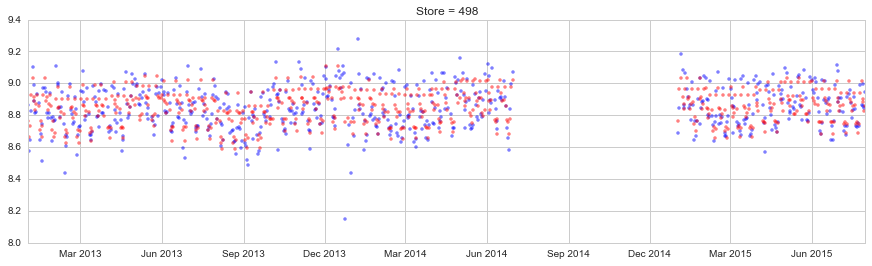

In [329]:
plotResult(models, 498)

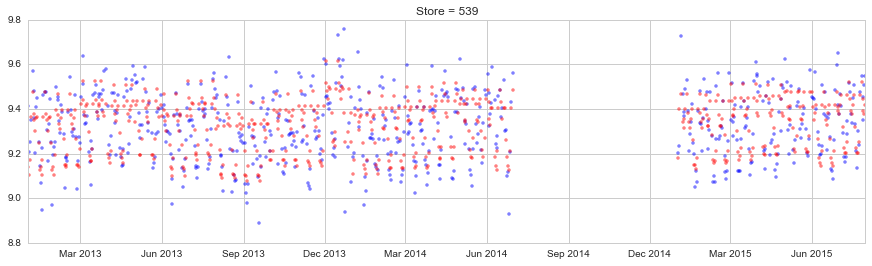

In [330]:
plotResult(models, 539)

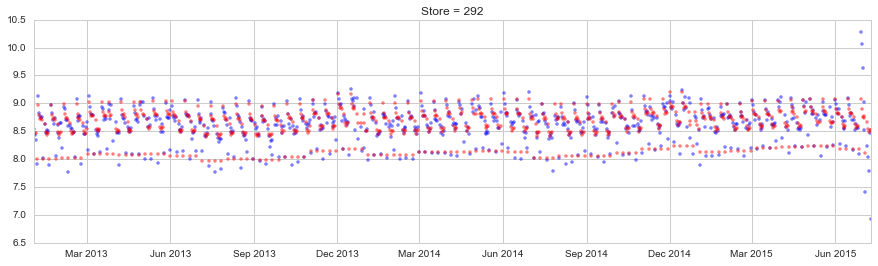

In [331]:
plotResult(models, 292)

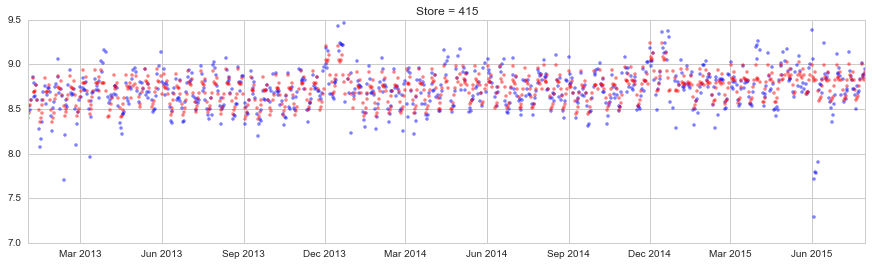

In [332]:
plotResult(models, 415)

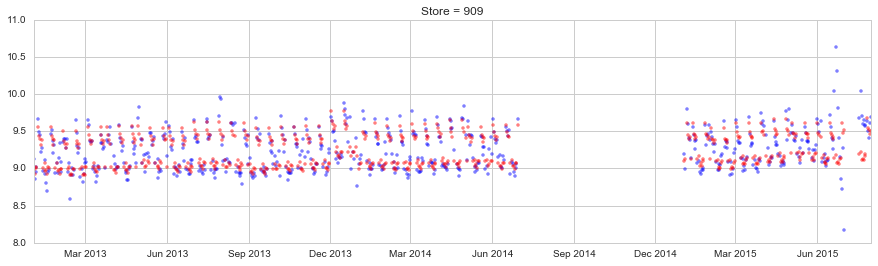

In [334]:
plotResult(models, 909)

In [234]:
#rmspes, models = trainModels(2, 'rfr', n_jobs=-1, n_estimators=100)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.141892203695
Model:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [335]:
#rmspes, models = trainModels(2, 'kr')

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.131524680848
Model:
KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)


## Make Predictions on Test data ##

In [355]:
def makePredictions(data):
    test_ids = []
    test_yhats = []

    grouped = data.groupby('Store')

    for storeId, group in grouped:
        x_drop_cols = ['Id', 'Open', 'Store', 'Date']

        ids = group['Id']
        X = group.drop(x_drop_cols, axis=1, inplace=False)

        yhat = np.exp(models[storeId].predict(X))

        # Ignore prediction and set Sales to zero hen the store is closed
        yhat[np.array(group['Open'] == 0)] = 0
        test_yhats += yhat.tolist()
        test_ids += ids.tolist()

    res = [[i, y] for i, y in zip(test_ids, test_yhats)]
    return sorted(res, key=lambda x: x[0])

In [356]:
result = makePredictions(test_data)

In [357]:
f = open("submission.csv", "w")
f.write('"Id","Sales"\n')

for r in result:
    f.write("%d,%d\n" % (r[0],int(r[1])))


In [354]:
# Quick check to make sure the file isn't corrupted.
df = pd.read_csv('submission.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41041 entries, 0 to 41040
Data columns (total 2 columns):
Id       41041 non-null int64
Sales    41040 non-null float64
dtypes: float64(1), int64(1)
memory usage: 961.9 KB


#### Misc stuff ####

In [225]:
def littleTest():
    # Test prediction using some input generated from training data
    random_idx = random.sample(train_df.index.tolist(), 100)

    try_df = train_df.loc[random_idx]
    try_y = try_df['Sales']
    try_df.drop(['Sales', 'Customers'], axis=1, inplace=True)
    try_df["Id"] = range(1, len(try_df) + 1)
    #try_data = transformData(pd.merge(try_df, store_df.ix[:,['StoreType', 'Assortment', 'Store']], on='Store'))
    try_data = transformData(try_df)

    result = makePredictions(try_data)
    try_yhat = np.array([r[1] for r in result])

    print rmspe(try_y, try_yhat)

In [340]:
littleTest()

1.177096525
